# A/B тест социальная сеть:

### A/A тест:
Задание 1:
В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между 0 и 1 группой не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы принимаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки с повторениями из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-06-06' по '2022-06-12'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values;

2. Посчитать, какой процент p values оказался меньше либо равен 0.05;

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

Импортируем нужные библиотеки и немного посмотрим на данные:

In [1]:
#Для датасета и статистики
import pandas as pd
import pandahouse as ph
import numpy as np
from scipy import stats
import pingouin as pg

#Для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

#Остальное
from tqdm.auto import tqdm

#Для классического bootstrap
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}  # установим связь с clickhouse

q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220720.feed_actions
WHERE toDate(time) between '2022-06-06' and '2022-06-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""  #введем нужный запрос

df = ph.read_clickhouse(q, connection=connection)

In [3]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


In [4]:
df.shape[0]

17049

In [5]:
df.dtypes

exp_group       int8
user_id       uint32
likes         uint64
views         uint64
ctr          float64
dtype: object

С типами данных у нас все нормально, теперь стоит посмотреть на пропущенные значения и посмотреть на распределения ctr в группах:

In [6]:
df.isna().sum()

exp_group    0
user_id      0
likes        0
views        0
ctr          0
dtype: int64

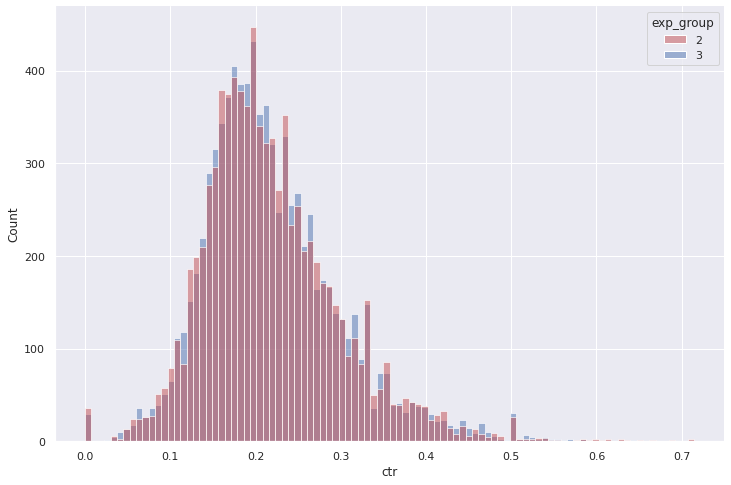

In [7]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize': (12, 8)})

groups = sns.histplot(data=df,
                      x='ctr',
                      hue='exp_group',
                      palette=['r', 'b'],
                      alpha=0.5,
                      kde=False)
sns.despine()

Чисто визуально мы можем сказать, что группы практически не отличаются по ctr, но при этом так точно не верно определять правильная ли у нас произошла разбивка.  Главная идея A/A тесты - это как раз проверить, что группы перед проведением эксперимента практически идентичны и для 2 групп нам поможет ttest. В процессе итерации по циклу он будет брать 2 выборки(в задание у нас по 500 значений) и обязательно без повторений, а после сравнивать гипотезу о равенстве средних. Дальше все p-value можно сложить куда-то, к примеру, в лист, а после посмотреть и если A/A тест покажет, что FPR у нас больше 0.05(так то можно взять и другой конечно же порог альфы), то с разбивкой что-то нет так.

<img src="https://raw.githubusercontent.com/CloudChaoszero/Presentations/d641be8e1d90dda482f9cc2a955990b1497277b2/PyBayTalks/2019/AB-Testing-Python/Resources/Images/a_a_test_meme.png">

Корректная система сплитования должна выглдяеть вот так:

<img src="https://raw.githubusercontent.com/0n1xx/AB_tests/5809f9e031d5e84b1c86d50c58ed95eb6cd69e65/Studies/AA_tests/different_fpr.png">

  0%|          | 0/10000 [00:00<?, ?it/s]

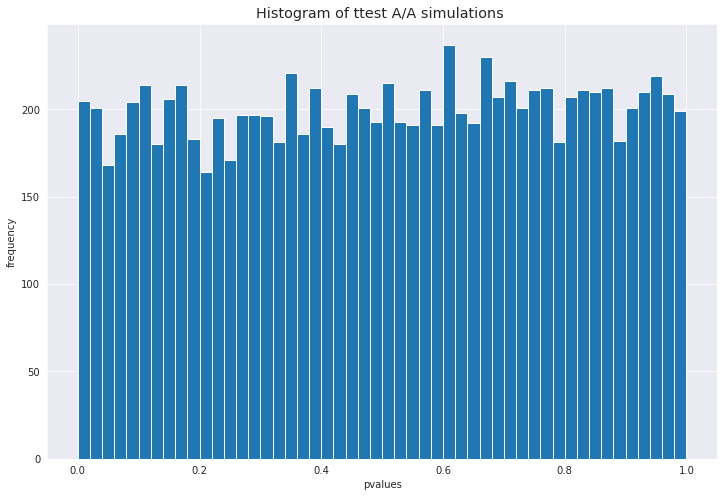

FPR = 0.0499


In [7]:
simulations = 10000
n_s = 500
res = []
# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df["exp_group"] == 2]["ctr"].sample(n_s, replace=False).values
    s2 = df[df["exp_group"] == 3]["ctr"].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.figure(figsize=(12, 8))
plt.hist(res, bins=50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()
# Проверяем, что количество ложноположительных случаев не превышает альфа
print(f"FPR = {sum(np.array(res) < 0.05) / simulations}")

В нашем случае система сплитования работает корректно так как p-value прокрасилось в допустимых границах и FPR получился ниже упомянутого выше  уровня альфы.

### A/B test:
Задание 2:
Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-06-13 по 2022-06-19 включительно. Для эксперимента были задействованы 2 и 1 группы.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля.

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Ваша задача — проанализировать данные АB-теста.

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования);
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали?
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте;
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


In [8]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220720.feed_actions
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""  #введем нужный запрос

df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Для начала я поставлю гипотезы, которые хочу проверить различными стат тестами и после посмотрю на их распределения:

Сначала было бы интересно посмотреть на средний в ctr в двух группах. Таким образом:
- H0: uCTR1 = uCTR2

Для проверки этой гипотезы нам может подойти t-test, но для начала построю распределения. Хоть и t-test не требует нормального распределения в выборках, при этом у него есть ситуации, в которых его лучше не использовать:

1. Распределение очень сильно скошено;
2. В распределении много выбросов;
3. В распределении очень высока вероятность больших по модулю отклонений (жирные выбросы — часть распределения).


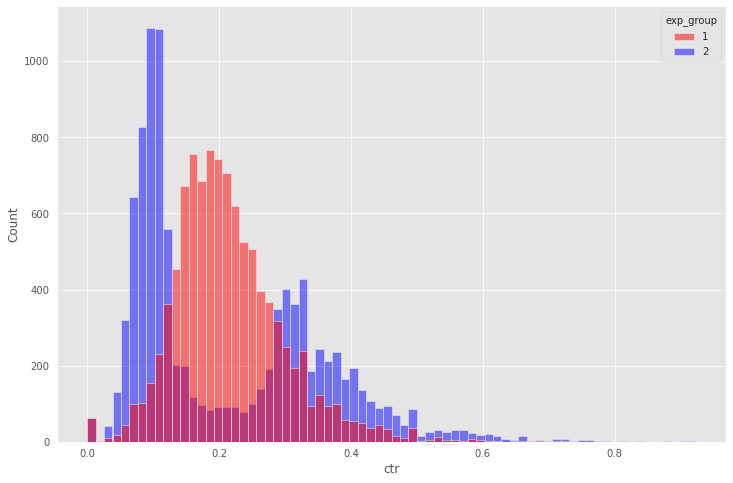

In [9]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

Чисто визуально мы можем сказать, что различие в средних в данных выборках точно есть, причем самое интересное, что в группе 2, где у нас был применен новый алгоритм, а соответственно средний ctr явно меньше чем в контрольной группе. Причем он даже похож на то, как обычно распределяется CTR, а именно экспонента с уклоном влево.

В данном случае я еще хочу построить boxplot, которые дадут более детальную картину:

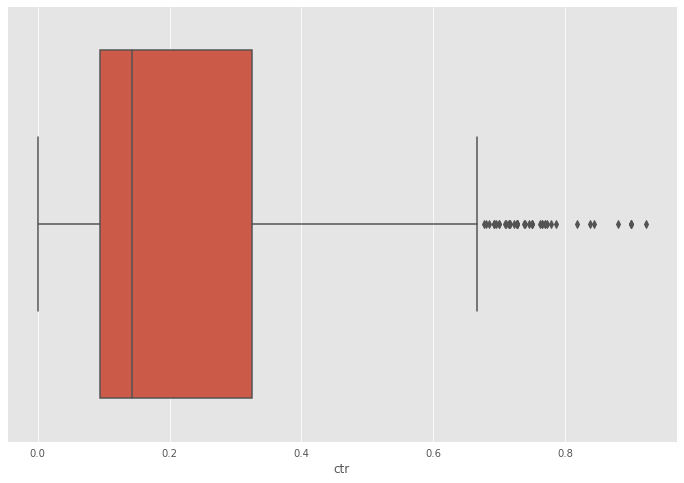

In [12]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=df[df["exp_group"] == 2]["ctr"])
sns.despine()

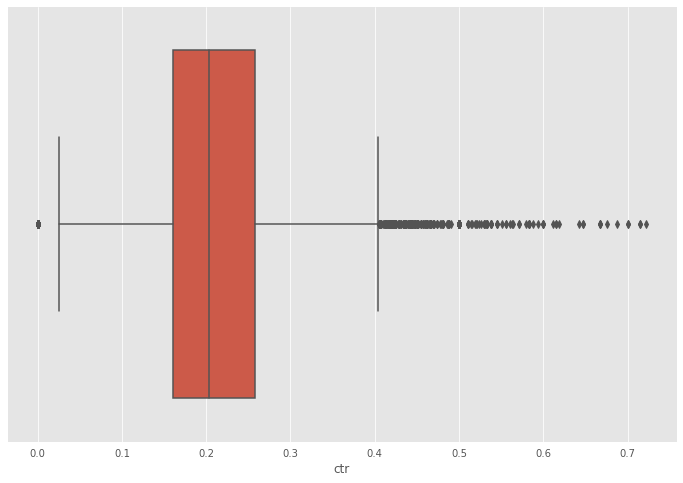

In [13]:
plt.figure(figsize=(12, 8))
sns.boxplot(x=df[df["exp_group"] == 1]["ctr"])
sns.despine()

И на гистплоте, и на боксплоте видно, что у нас есть выбросы, также можно точно убедиться что распределения не являются нормальными, используя тест Шапиро-Уилка:
- Нулевая гипотеза H0 теста Шапиро–Уилка заключается в том, что случайная величина, выборка x которой известна, распределена по нормальному закону.
- Альтернативная гипотеза H1 заключается в том, закон распределения не является нормальным;
- Порог альфы - 0.05

In [16]:
df_for_shapiro = df.sample(n=1000,random_state=42) # Берем меньше чем 5000 значений, так как это одно из требований критерия

In [17]:
pg.normality(data=df_for_shapiro, dv="ctr", group="exp_group")

,W,pval,normal
1,0.95931,1.058741e-10,False
2,0.87728,3.473645e-19,False


Здесь он нас предупреждает, что p-value мб не точным, при этом в совокупности с графиком точно можно понять, что обе переменные распределены ненормально, хотя в контрольной группе распределение выглядит +- похожее в нормальному.

Все же сначала хочу проверить гипотезу о равенстве распределений в двух группах:
- H0: распределение в тестовой группе не отличается от контрольной;

In [18]:
stats.mannwhitneyu(df[df['exp_group'] == 1]["ctr"], df[df['exp_group'] == 2]["ctr"])

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

- p-value нам подсказывает отклонить H0. При этом у данного критерия очень неудобная в интерпретации H0, здесь имеется в виду, что для людей, которые хотят услышать ответ, увеличилось ли что-то или нет она явно будет не очень понятная так как обычно люди, которые спрашивают нас о результатах эксперимента хотят услышать, что среднее что-то увеличилось или нет.

- Далее мне бы хотелось бы посмотреть на сглаженный ctr и под сглаженным ctr я понимаю следующее:
     - smoothctr = clicks + a * globalctr / views + a

- Хоть идея сглаженного CTR интуитивно понятна, теоретической гарантии, что его
направленность совпадает с направленностью общего количества кликов, нет.

In [19]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [20]:
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()  #для контрольной группы
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()  #для тестовой группы

In [21]:
test_group = df[df["exp_group"] == 2]
control_group = df[df["exp_group"] == 1]

In [22]:
#Считаем smoothctr для каждой группы, а после снова объединяем их в общий датафрейм:
test_group["smooth_ctr"] = test_group.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
control_group["smooth_ctr"] = control_group.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
all_groups = pd.concat([test_group, control_group])
all_groups.head()

/tmp/ipykernel_253107/1556195859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group["smooth_ctr"] = test_group.apply(
/tmp/ipykernel_253107/1556195859.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group["smooth_ctr"] = control_group.apply(


,exp_group,user_id,likes,views,ctr,smooth_ctr
5,2,131473,14,134,0.104478,0.107844
6,2,23985,7,87,0.080460,0.086851
7,2,24523,11,101,0.108911,0.113116
8,2,32420,26,128,0.203125,0.202935
9,2,24239,40,90,0.444444,0.431477


А теперь я хочу посмотреть на распределения:

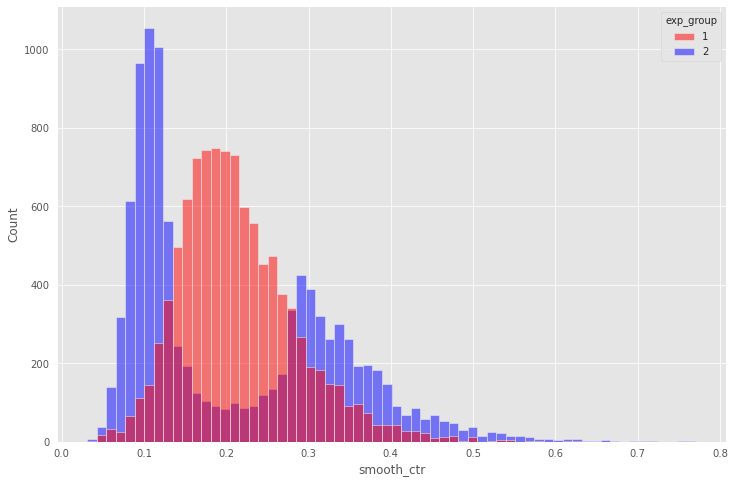

In [23]:
plt.figure(figsize=(12, 8))
sns.histplot(data=all_groups,
             x='smooth_ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

- В целом особых изменений тут нет по сравнению с распределением обычных ctr. Единственное можно заметить, что в контрольной группе все же ctr немного сгладился.

- Дальше я хочу попробовать применить бакетное преобразование и там уже проверить гипотезы, использую ttest и Манна-Уитни.

- Но для начала я хочу подумать над размер каждого бакета.

In [24]:
all_groups.shape[0]

20031

Здесь можно взять число 50 за размер бакета, вообще как я понял идея бакетного преобразования - это то что мы делил нашу выборку на несколько выборок и у нас получаются псевдовыборки и после по каждой псевдовыборки мы считаем ctr. Есть также и ограничения у данного способа: чтобы каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. Это можно гарантировать с помощью того же хеширования с солью.
Из лекции сделаю это также в clickhouse:

In [25]:
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220720.feed_actions
    WHERE toDate(time) between '2022-06-13' and '2022-06-19'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


А теперь я хочу посмотреть на распределения:

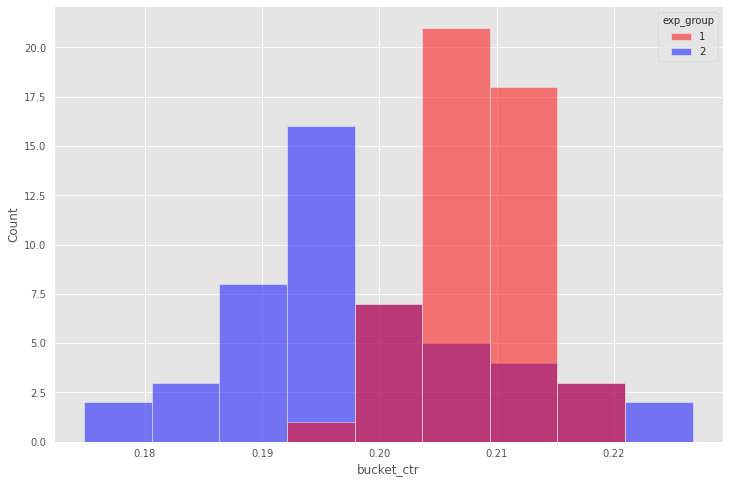

In [26]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='bucket_ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

- Распределения стали +- похожи на нормальные, здесь хотя бы отчетливо видно, что они оба унимодальны(то есть имеют оди горб);
- А теперь я хочу проверить гипотезу о разнице в средних используя ttest;
- H0: средний ctr в группах не отличается.

При этом у классического ttest есть одно обязательное требование - это гомогенность дисперсий и это можно проверить с помощью критерия Левена или критерия Бартлетта:

In [27]:
stat, p = stats.levene(df[df["exp_group"] == 1]["bucket_ctr"], df[df["exp_group"] == 2]["bucket_ctr"])
p

8.092371176109902e-05

p-value не позволяет нам принять H0, но при этом здесь мы можем использовать welch ttest, который как раз рассчитан на те случаи, когда у нас разная дисперсия между групп:

In [28]:
stats.ttest_ind(df[df["exp_group"] == 1]["bucket_ctr"], df[df["exp_group"] == 2]["bucket_ctr"], equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

Исходя из p-value мы можем отклонить H0, а значит разницы между ctr в группах есть:

In [29]:
display(df[df["exp_group"] == 1]["bucket_ctr"].mean(), df[df["exp_group"] == 2]["bucket_ctr"].mean())

0.2081217072433601

0.19825944666552936

Причем в контрольной группе у нас средне значение выше чем в тестовой. Дальше я хочу проверить гипотезу о равенстве распределений на бакетных ctr:
- H0: распределение ctr между группами не отличается.

In [30]:
stats.mannwhitneyu(df[df["exp_group"] == 1]["bucket_ctr"], df[df["exp_group"] == 2]["bucket_ctr"])

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

И снова p-value говорит нам, что различия в распределениях между группами есть. На последок хочу проверить гипотезу о равенстве средних значений между группами при этом использую непараметрический и классический boostrap. Далее я немного попишу про bootstrap, чтобы понять для себя основные различие между обычным и классическим boostrap;
1. Классический boostrap - это обычный ресэплинг выборок. Здесь я имею в виду вот что: мы берем сэмл из 1 группы, сэмл из второй группы, после вычитаем выбранную нами заранее статистику, считаем ее у двух сэмлов, а далее вычитаем второе из первого.
2. Непараметрический же bootstrap: в данном случае в каждой ресемпле мы считаем сколько раз данное наблюдение попало к нам в выборку и здесь алгоритм такой(алгоритм на примере подсчета ctr):
    - Берем выборку из группы А (у нас это user_id с его views и clicks)
    - Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку». Получается колонка, отражающая «вес» пользователя. Назовем ее weights1
    - Считаем «глобальный CTR» по псевдовыборке для A:
        - globalCTR = sum(likes) * weight / sum(views) * weight
    - Тоже самое делаем для группы B;
    - Считаем разницу между globalCT RA − globalCT RB и записываем эту разность, например, в список;
    - Повторяем процедуру много раз, например, 2000.

In [31]:
def poison_bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes2))).astype(np.int64)
    globalCTR1 = (poisson_bootstraps1 * likes1).sum(axis=1) / (poisson_bootstraps1 * views1).sum(axis=1)
    globalCTR2 = (poisson_bootstraps2 * likes2).sum(axis=1) / (poisson_bootstraps2 * views2).sum(axis=1)
    return globalCTR1, globalCTR2

Далее я снова бы хотел переопределить переменную df:

In [32]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220720.feed_actions
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""  #введем нужный запрос
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


Подготавливаем все нужные переменные и применяем непараметрический bootstrap:

In [33]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [34]:
ctr1, ctr2 = poison_bootstrap(likes1, views1, likes2, views2)

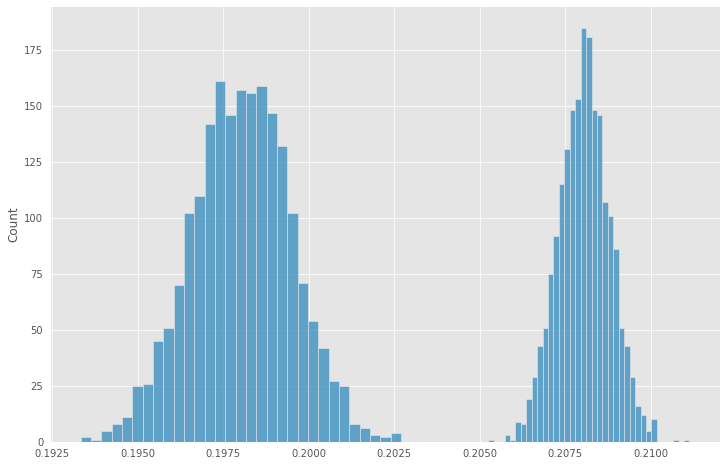

In [35]:
plt.figure(figsize=(12, 8))
sns.histplot(ctr1)
sns.histplot(ctr2)
sns.despine()

Видно, что разница точно есть, а теперь сделаем вычет вторых значений из первых, то есть все значения тестовых из контрольных:

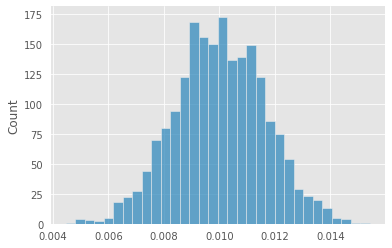

In [36]:
#Разница между глобальными CTR
sns.histplot(ctr1 - ctr2)
sns.despine()

Ну а теперь я хочу проверить гипотезу о равенстве средних между группами используя обычный boostrap и для этого есть как метод в scipy, так и целая библиотека:

In [37]:
#Исходя из документации значения должны быть типа array
a_group_ctr = np.array(df[df["exp_group"] == 1]["ctr"])
b_group_ctr = np.array(df[df["exp_group"] == 2]["ctr"])

In [38]:
print(bs.bootstrap_ab(a_group_ctr, b_group_ctr, bs_stats.mean, bs_compare.percent_change))

0.5528070863034872    (-1.0107066940789766, 2.0381908216438593)


- А вот здесь доверительный интервал подсказывает что различий нету;
- Далее хотел бы посмотреть еще раз на график и сделать уже финальные выводы.

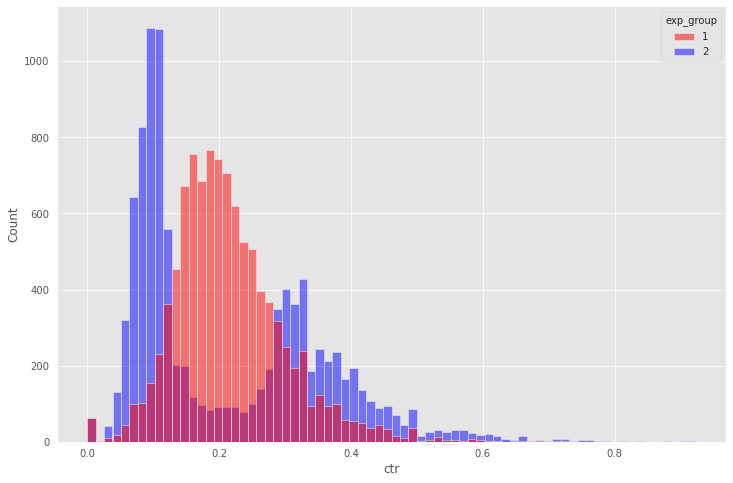

In [39]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='ctr',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

В начале исследования я не написал предположения что могло случиться в тестовой группе ведь у нас среднее значение ctr в контроле выше чем в тесте, а это явно не то, что я ожидал. Мои гипотезы почему так могло случиться:
1. Проблема с реализацией алгоритма, здесь я имею в виду, что он стал хуже находить посты, которые нам нравятся;
2. Мб не хватило времени для сбора показателей или кол-во пользователей в каждой выборке не хватало.

### Выводы исходя из общих показателей:
1. Я бы не рекомендовал расскатывать новую систему рекомендаций, так как исследования показали, что средний ctr в тестовой группе будет меньше по сравнению с контролем;
2. При этом все тесты показали что различие между группами есть, единственное классический boostrap не позволил отклонить H0. При этом я бы все же отвергнул H0 и признал что новый алгоритм хуже старого на основе выше приведенных исследований.

### A/B test:
Задание 3:
Разобранными на лекции методами список того, что можно применять к метрикам-отношениям, не ограничивается. Есть огромное количество полезных [материалов](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3) на эту темы. Начнем с материалов Никиты Маршалкина. К слову, вот его [интервью](https://www.youtube.com/watch?v=gljfGAkgX_o&t=19s), там тоже много интересного.

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями
(прямо как у нас) вида likes/clicks.

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

1. Считаем общий CTR в контрольной группе: CTRcontrol=sum(likes)/sum(views);
2. Посчитаем в обеих группах поюзерную метрику: linearized_like=likes - CTRcontrol * views;
3. После чего сравним  t-тестом отличия в группах по метрике linearized_like.

Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача

- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли p-value меньше?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли p-value меньше?

Сначала займусь группами 1 и 2:
____

In [40]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220720.feed_actions
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""  #введем нужный запрос
df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,33,122,0.270492


Для начала хочу проверить о равенстве лайков между группами, а после провести несколько исследований по линеризованной версии, но для начала посмотрю на распределение лайков по группам:

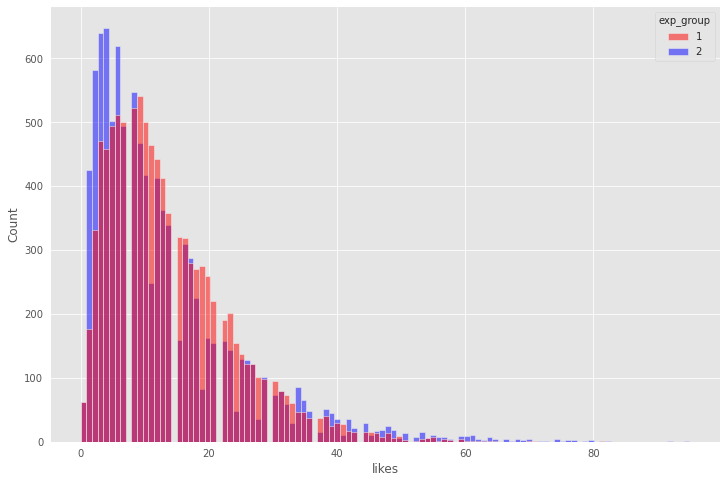

In [41]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='likes',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

Из графика видно, что это распределение очень похоже на экспоненциальное с уклоном влево, поэтому для проверки гипотезы о равенстве среднего кол-во лайков имеет смысл использовать boostrap. Хоть и ttest не требует нормального распределения в выборках, но при этом его не очень корректно использовать при больших скосах, а тут они явно есть. Также я хотел бы использовать функцию, которую я позаимствовал из этого [видео](https://www.youtube.com/watch?v=-zps6hm0nX8).

In [42]:
def get_bootstrap(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        statistic=np.mean,  # интересующая нас статистика
        bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True  # параметр возвращения
        ).values

        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values

        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = stats.norm.cdf(
        x=0,
        loc=np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0,
        loc=-np.mean(boot_data),
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)

    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {"boot_data": boot_data,
            "ci": ci,
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

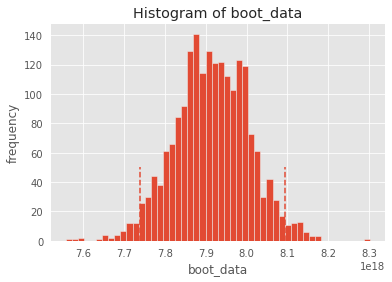

In [43]:
bootstraped = get_bootstrap(df[df["exp_group"] == 1]["likes"], df[df["exp_group"] == 2]["likes"], boot_it=2000)

In [44]:
bootstraped["p_value"]

0.0

Параметрический boostrap точно говорит, что H0 нужно отклонить, а теперь я хочу посмотреть на результаты ttest, при этом как и писал выше я бы не доверился ему в данном случае:

In [45]:
stats.ttest_ind(df[df["exp_group"] == 1]["likes"], df[df["exp_group"] == 2]["likes"])

Ttest_indResult(statistic=4.5009779453960395, pvalue=6.8022465156141964e-06)

- p-value в результате ttest нам тоже подталкивает отклонить H0.
- А далее я посчитаю метрику как линеризованные лайки и проверю несколько гипотез на ней:

In [46]:
control_group = df[df["exp_group"] == 1]
ctr_control = control_group["likes"].sum() / control_group["views"].sum()

In [47]:
ctr_control

0.20802680490126244

In [48]:
df["linearized_like"] = df["likes"] - df["views"] * ctr_control

Метрика посчитана, а теперь хочется на нее посмотреть:

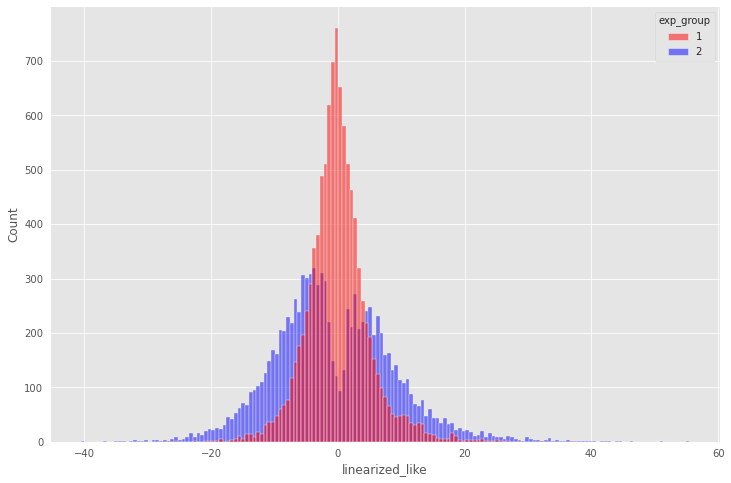

In [49]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='linearized_like',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

Данный гистплот ну прям очень напоминает нормальное распределение.

- Раз уж у нас распределение линеризированных лайков очень похоже на нормальное то сначала я просто хочу применить t-test, таким образом:
    - H0: среднее кол-во линеризированных лайков в группах не отличается.

In [50]:
stats.ttest_ind(df[df["exp_group"] == 1]["linearized_like"], df[df["exp_group"] == 2]["linearized_like"])

Ttest_indResult(statistic=6.145218242325588, pvalue=8.136173836093922e-10)

p-value подсказывает нам отклонить H0.

In [51]:
display(df[df["exp_group"] == 1]["linearized_like"].mean(), df[df["exp_group"] == 2]["linearized_like"].mean())

-2.821656215775177e-16

-0.6592771236485152

Здесь средние значения не очень понятные, ведь как может быть минусовое кол-во лайков. При этом в данной метрике гарантируется, что если она прокраситься, то и в оригинальной метрики есть изменения, так что есть смысмл посмотреть на среднее кол-во лайков в группах:

In [52]:
display(df[df["exp_group"] == 1]["likes"].mean(), df[df["exp_group"] == 2]["likes"].mean())

13.792142077587062

13.101386655948554

Здесь контроль также показывает большее кол-во средних лайков. При этом я также хочу посмотреть на медианное кол-во линеризированных лайков и для этого мне поможет параметрический boostrap, таким образом:
- H0: медианное значение лайков в группах одинаковое.

In [53]:
a_group_linearized_likes = np.array(df[df["exp_group"] == 1]["linearized_like"])
b_group_linearized_likes = np.array(df[df["exp_group"] == 2]["linearized_like"])

In [54]:
print(bs.bootstrap_ab(a_group_linearized_likes, b_group_linearized_likes, bs_stats.median, bs_compare.percent_change))

-89.33155335475345    (-95.18920289334427, -85.10667215385801)


- Доверительный интервал в boostrap также не позволяет нам принять H0;
- Последнее что я бы хотел проверить - это распределения линеризованных лайков в группах, таким образом:
- H0: распределения линеризованных лайков в группах одинаковое.

In [55]:
stats.mannwhitneyu(np.array(df[df["exp_group"] == 1]["linearized_like"]),
                   np.array(df[df["exp_group"] == 2]["linearized_like"]))

MannwhitneyuResult(statistic=54534537.0, pvalue=9.404319579641738e-27)

Манна-Уитни также не позволяет нам принять H0.

### Выводы по группе 1 и 2:
1. Кол-во лайков в контроле(1 группе) будет больше и исходя из всех тестов, которые я провел выше. Можно сказать, что разница в группах есть как по среднему, медиане так и в целом по распределению;
2. p-value при этом осталось также ниже вышеобговоренного уровня альфа(0.05).

А теперь сделаю тоже самое, но для группы 0 и 3:
____

In [56]:
q = """
SELECT exp_group,
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220720.feed_actions
WHERE toDate(time) between '2022-06-13' and '2022-06-19'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""  #введем нужный запрос

df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [57]:
df.dtypes

exp_group       int8
user_id       uint32
likes         uint64
views         uint64
ctr          float64
dtype: object

In [58]:
df.isna().sum()

exp_group    0
user_id      0
likes        0
views        0
ctr          0
dtype: int64

С типами данных проблем нету, а также пустых значений у нас не наблюдается. Также как и с прошлыми группами сделаю тоже самое.

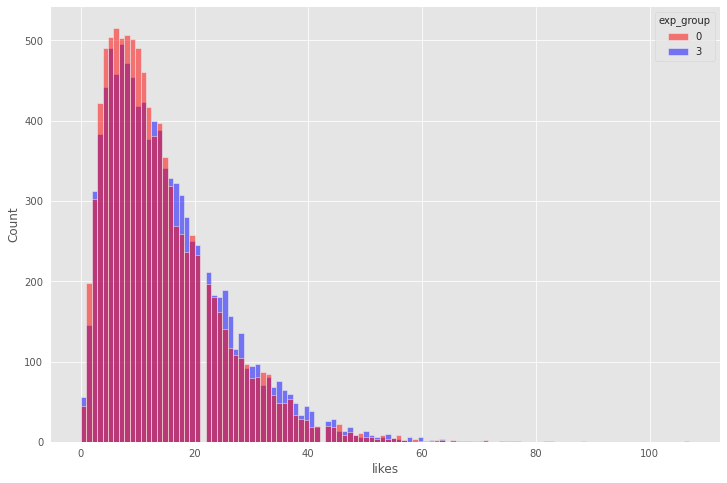

In [59]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='likes',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

- Как и в прошлый раз у нас явно есть экспоненциальное распределение влево;
- Далее проверю гипотезу о равенстве среднего кол-во лайков у разных групп при помощи ttest и boostrap.
- H0: среднее значение между группами не отличается.

  0%|          | 0/2000 [00:00<?, ?it/s]

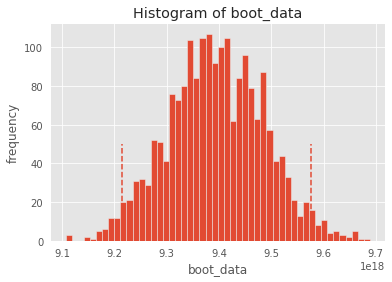

In [60]:
bootstraped = get_bootstrap(df[df["exp_group"] == 0]["likes"], df[df["exp_group"] == 3]["likes"], boot_it=2000)

In [61]:
bootstraped["p_value"]

0.0

Как и в прошлом эксперименте p-value не позволяет принять H0.

In [62]:
stats.ttest_ind(df[df["exp_group"] == 0]["likes"], df[df["exp_group"] == 3]["likes"])

Ttest_indResult(statistic=-6.706667855931314, pvalue=2.0442582488023223e-11)

И p-value тоже показывает, что не стоит принимать H0. При этом далее я хочу посмотреть на среднее значение лайков, а также создать метрику как линеризованные лайки.

In [63]:
display(df[df["exp_group"] == 0]["likes"].mean(), df[df["exp_group"] == 3]["likes"].mean())

13.987598759875988

14.962583341626033

Как можно видеть, что в группе 3 среднее кол-во лайков отличается. Также хочу себе записать, что группа 3 - это тестовое группа, а 0 - контрольная.

In [64]:
control_group_new = df[df["exp_group"] == 0]
ctr_control_new = control_group["likes"].sum() / control_group["views"].sum()

In [65]:
ctr_control_new

0.20802680490126244

In [66]:
df["linearized_like"] = df["likes"] - df["views"] * ctr_control

Теперь я хочу посмотреть на распределения линеризованных лайков:

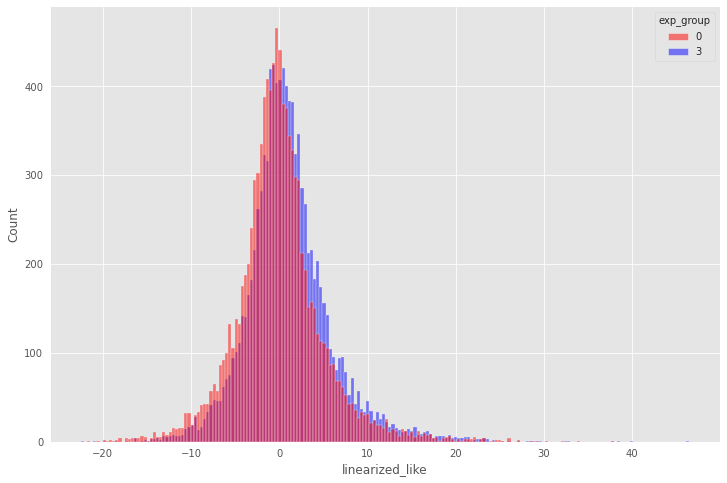

In [67]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df,
             x='linearized_like',
             hue='exp_group',
             palette=['r', 'b'],
             alpha=0.5,
             kde=False)
sns.despine()

Как и в прошлый раз распределение +- похоже на нормальное. В этот раз я использую для проверки ttest и таким образом:
- H0: среднее кол-во лайках в группах не отличаются.

In [68]:
stats.ttest_ind(df[df["exp_group"] == 0]["linearized_like"], df[df["exp_group"] == 3]["linearized_like"])

Ttest_indResult(statistic=-15.21692351429564, pvalue=5.33281411712014e-52)

Исходя из p-value мы можем отклонить H0.

### Выводы по группе 0 и 3:
1. Кол-во лайков в тестовой группе(3) будет больше по сравнению с контрольной исходя из вышепроведенного исследования.
2. При этом p-value был меньше уровня альфы как при сравнении гипотезы о средних на обычных лайках, так и на линеризованных.